# Model Diagnostics

In this notebook we will learn how to evaluate and diagnose model performance. We will run our first experiment and see if we can improve the performance of our model trained in the previous notebook.   

1. Performance: measure model performance with `Correlation`  
2. Risk: measure model risk with `Sharpe`, `Max Drawdown`, `Feature Exposure` 
3. Experiment: use `Feature Neutralization` to reduce risk and improve performance

In [28]:
# Install dependencies
!pip install -q numerapi pandas matplotlib lightgbm pyarrow cloudpickle

## Performance

Let's use the model we trained in the previous notebook and evaluate its performance with the validation dataset. 

In [29]:
from numerapi import NumerAPI
napi = NumerAPI()

# Let's download the validation dataset and feature metadata
# This will take about 2 minutes 🍵
napi.download_dataset("v4.1/validation.parquet");
napi.download_dataset("v4.1/features.json");

2023-04-26 13:46:55,738 INFO numerapi.utils: target file already exists
2023-04-26 13:46:55,739 INFO numerapi.utils: download complete
2023-04-26 13:46:56,168 INFO numerapi.utils: target file already exists
2023-04-26 13:46:56,169 INFO numerapi.utils: download complete


In [30]:
import pandas as pd
import json

# Like before, we will be using the "small" feature set to save time and memory
feature_metadata = json.load(open("v4.1/features.json")) 
feature_cols = feature_metadata["feature_sets"]["small"]

# Load the validation data but only the "small" subset of features
# This time we also load the "data_type" column so that we can filter against it
validation_data = pd.read_parquet("v4.1/validation.parquet", columns=["era", "data_type"] + feature_cols + ["target"]) 

# Filter for data_type == "validation" and drop the "data_type" column after as we no longer need it
validation_data = validation_data[validation_data["data_type"] == "validation"]
del validation_data["data_type"]

In [31]:
# The structure of the validation dataset is the same as the training dataset
# Notice the eras pick up where the training dataset eras left off
# This is because the validation dataset is a continuation of the training dataset
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 5)
validation_data

,era,feature_bijou_penetrant_syringa,...,feature_unventilated_sollar_bason,target
id,,,,,
n000101811a8a843,0575,0.25,...,0.75,0.50
n001e1318d5072ac,0575,0.50,...,0.75,0.00
n002a9c5ab785cbb,0575,0.25,...,0.25,0.50
n002ccf6d0e8c5ad,0575,0.25,...,0.00,0.25
n0051ab821295c29,0575,1.00,...,1.00,0.50
...,...,...,...,...,...
nffb8aae0a11ec68,1054,0.50,...,1.00,0.75
nffd34b1e7d9fee9,1054,0.25,...,0.50,0.75
nffe5b20d83070b0,1054,0.00,...,0.25,0.00


In [32]:
import lightgbm as lgb

# Let's load the model we trained in the previous notebook
# If you are getting an error here, make sure you have run the previous notebook first!
model = lgb.Booster(model_file='small_lgb.txt')

# And make predictions against the validation features
# This will take about 2 minutes 🍵
predictions = model.predict(validation_data[feature_cols])

In [33]:
# Let's take a look at our predictions compared to target values
validation_data["prediction"] = predictions
validation_data[["era", "prediction", "target"]]

,era,prediction,target
id,,,
n000101811a8a843,0575,0.483958,0.50
n001e1318d5072ac,0575,0.494990,0.00
n002a9c5ab785cbb,0575,0.501213,0.50
n002ccf6d0e8c5ad,0575,0.507834,0.25
n0051ab821295c29,0575,0.484320,0.50
...,...,...,...
nffb8aae0a11ec68,1054,0.496288,0.75
nffd34b1e7d9fee9,1054,0.496277,0.75
nffe5b20d83070b0,1054,0.492815,0.00


Numerai uses a special correlation metric to evaluate the performance of models. At a high level, this metric is designed to be a good proxy for actual portfolio returns if the predictions were used in live trading.
- First the predictions are <ins>gauss ranked</ins>. We do this to match our live trading process where all model predictions are standardized this way before being ensembled together in the meta model.
- Then the target is <ins>centered</ins> around 0. We do this to match the guass ranked predictions which are now centered around 0. 
- Finally both the gauss ranked predictions and the cenetered target are <ins>raised to the power of 1.5</ins> before calculating the Pearson correlation. We do this to accentuate the tails as hedge fund tends to only trade the stocks with highest or lowest predicted returns.

The key takeaway here is that your prediction's distribution does not matter. You are only evaluated on your prediction's ranks. And your score depends more on the tails than a typical rank-correlation.

In [34]:
from scipy import stats
import numpy as np

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then Gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0 instead of 0.5
    centered_target = target - 0.5
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5 
    target_p15 = np.sign(centered_target) * np.abs(target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

Now let's calculate the correlation between our predictions and the target values.

We compute all metrics per-era since that is how our live submissions will be evaluated.

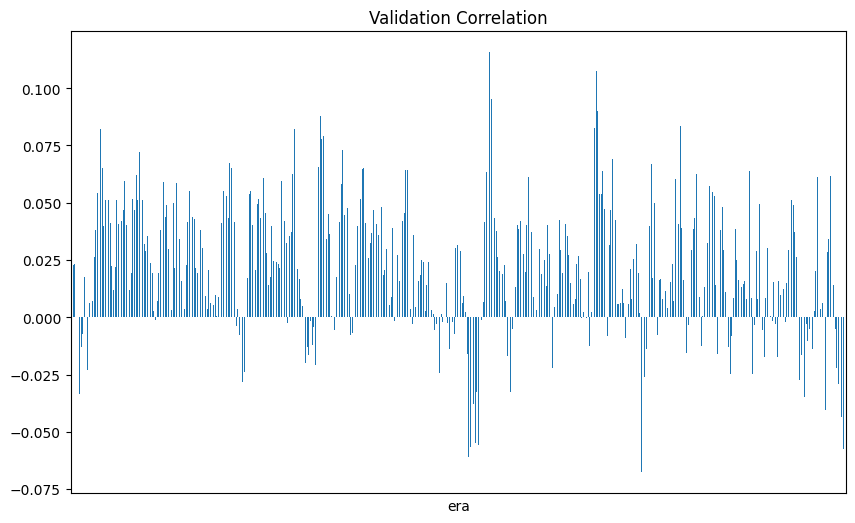

In [50]:
# Compute the per-era correlation between our predictions and the target values
per_era_validation_correlation = validation_data.groupby("era").apply(lambda x: numerai_corr(x["prediction"], x["target"]))

# Plot the per-era correlation
per_era_validation_correlation.plot(kind="bar", title="Validation Correlation", figsize=(10, 6), xticks=[]);

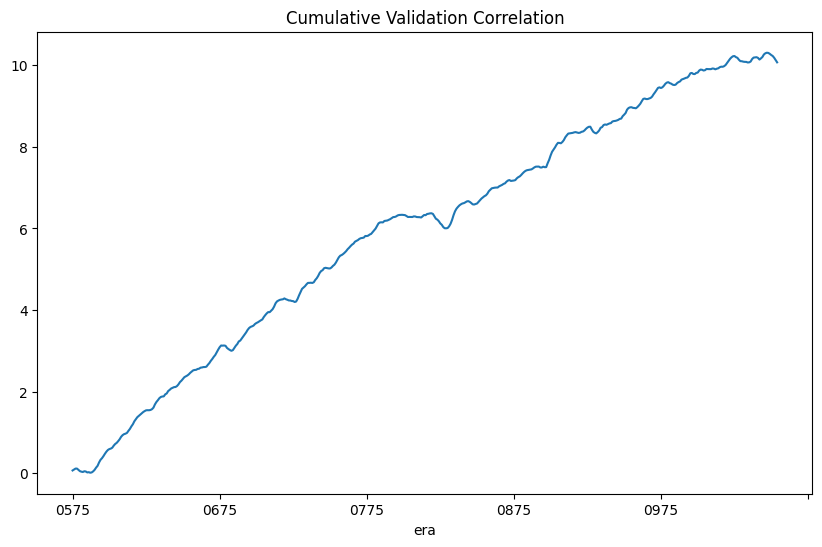

In [36]:
# Another way to visualize our model performance is to look at the cumulative correlation over time
# If you have ever seen a backtest of a trading strategy, this is similar but not quite mathematically the same
cumulative_per_era_validation_correlation = per_era_validation_correlation.cumsum()

# Plot the cumulative correlation
cumulative_per_era_validation_correlation.plot(title="Cumulative Validation Correlation", figsize=(10, 6));

In [37]:
# What is the average correlation across all eras?
# You should aim for a correlation mean of at least 0.03 to be considered a good model
# 0.02 is not great but also not terrible considering we only used the "small" feature set
correlation_mean = per_era_validation_correlation.mean()
correlation_mean

0.020981073102123285

## Risk

In finance, risk refers to the degree of uncertainty and/or potential for financial loss. In Numerai, risk refers to the degree of uncertainty and/or potential for poor model performance.  

There is no single mathematical definition of risk, but there are useful ways for us to talk about the different aspects of it:
- `Numerai Sharpe`: a measure of a model's risk-adjusted performance, where risk is modeled as the standard deviation of correlation
- `Numerai Max Drawdown`: a measure of the magnitude of a model's worst period of performance, from peak to trough
- `Feature Exposure`: a measure of a model's correlation to individual features, which are themselves considered risky    

In [38]:
# Sharp ratio is a common metric in finance used to measure the risk-adjusted performance of an investment strategy
# In finance, the Sharpe ratio is computed as the average return minus the risk free rate divided by the standard deviation of the return
# The higher the Sharpe ratio, the better and more consistent the investment strategy
# In Numerai, we compute the Sharpe ratio as the average correlation divided by the standard deviation of the correlation
# You should aim for a Numerai Sharpe ratio of at least 1.0 to be considered a consistent model
correlation_std = per_era_validation_correlation.std(ddof=0)
numerai_sharpe = correlation_mean / correlation_std
numerai_sharpe

0.7277660456735534

In [39]:
# Max drawdown is a common metric in finance used to measure the worst case scenario of an investment strategy
# Typically, max drawdown is computed as the difference between the highest peak and lowest trough of the cumulative returns
# In Numerai, we compute the max drawdown as the difference between the highest peak and lowest trough of the cumulative correlation
# You should aim to minimize the max drawdown of your model but how much you care about this versus maximizing the correlation mean is up to you
rolling_max = cumulative_per_era_validation_correlation.expanding(min_periods=1).max()
max_drawdown = (rolling_max - cumulative_per_era_validation_correlation).max()
max_drawdown

0.3677745910371062

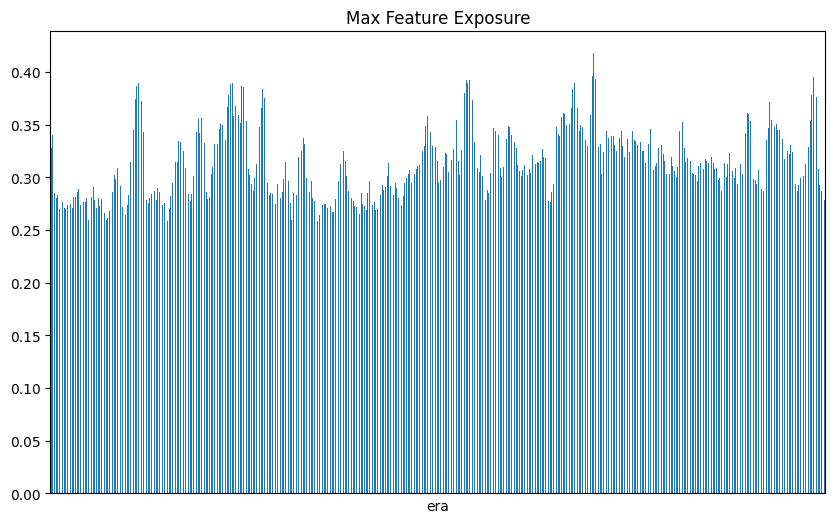

In [40]:
# Feature exposure is a metric that measures how correlated a model is with any single single feature
# Having high correlation with single features is considered risky because individual features are known to be risky
max_feature_expposure_per_era = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["prediction"]).abs().max())

# Plot the max feature exposure per era
# The max feature exposure quantifies how exposed your model is to the risk of any single feature
max_feature_expposure_per_era.plot(title="Max Feature Exposure", kind="bar", figsize=(10, 6), xticks=[]);

In [41]:
# Mean max feature exposure across eras
max_feature_exposure_mean = max_feature_expposure_per_era.mean()
max_feature_exposure_mean

0.3135921368407573

## Experiment

Now that we have learned how to compute the performance and risk metrics, we are ready to run our first experiment.

`Feature Neutralization` is a way to reduce `Feature Exposure`. Let's try to neutralize our predictions and see if we can improve our performance.

In [42]:
# Compute the orthogonal component of the predictions with regards to the feature matrix
# Proportion controls how much of the exposure to neutralize, where 1.0 means 100% of the exposure is neutralized
def neutralize(predictions, features, proportion=1.0):
    # given predictions p and feature matrix F, the orthogonal component p' with regards to F is:
    # p' = p - (F dot (F_inverse dot p))
    inverse_features = np.linalg.pinv(features.values, rcond=1e-6)
    exposure = proportion * features.values.dot(inverse_features.dot(predictions))
    return predictions - exposure

In [43]:
# Neutralize predictions per-era againat the features we used for training
neutralized_per_era = validation_data.groupby("era").apply(lambda d: neutralize(d["prediction"], d[feature_cols]))

# Align the neutralized predictions with the validation data
validation_data["neutral_prediction"] = neutralized_per_era.reset_index().set_index("id")["prediction"]
validation_data[["era", "prediction", "neutral_prediction", "target"]]

,era,prediction,neutral_prediction,target
id,,,,
n000101811a8a843,0575,0.483958,0.073401,0.50
n001e1318d5072ac,0575,0.494990,-0.038767,0.00
n002a9c5ab785cbb,0575,0.501213,0.069088,0.50
n002ccf6d0e8c5ad,0575,0.507834,0.061221,0.25
n0051ab821295c29,0575,0.484320,0.018759,0.50
...,...,...,...,...
nffb8aae0a11ec68,1054,0.496288,0.082000,0.75
nffd34b1e7d9fee9,1054,0.496277,0.008087,0.75
nffe5b20d83070b0,1054,0.492815,-0.071625,0.00


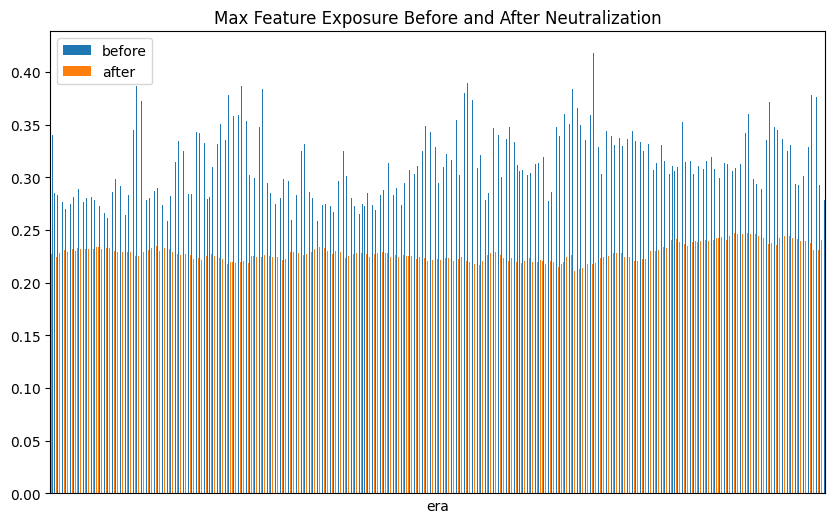

In [44]:
# Compute the per-era correlation between our neutralized predictions and the target values
max_feature_exposure_per_era_neutral = validation_data.groupby("era").apply(lambda d: d[feature_cols].corrwith(d["neutral_prediction"]).abs().max())

# Plot the max feature exposure per era before and after neutralization side by side 
pd.DataFrame({"before": max_feature_expposure_per_era, "after": max_feature_exposure_per_era_neutral}).plot(title="Max Feature Exposure Before and After Neutralization", kind="bar", figsize=(10, 6), xticks=[]);

Great! Looks like we have succesfully reduced our max feature exposure. Now let's check the other performance metrics before vs after neutralization.

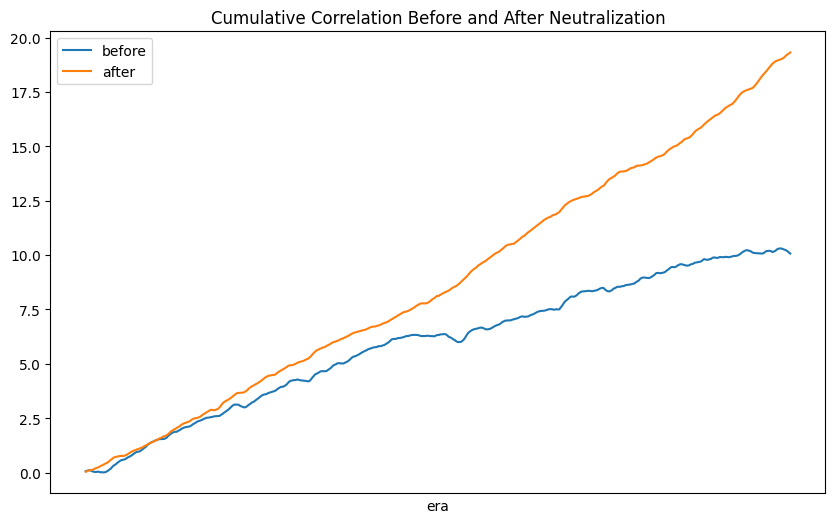

In [45]:
# Plot cumulative correlation before and after neutralization side by side
per_era_validation_correlation_neutral = validation_data.groupby("era").apply(lambda x: numerai_corr(x["neutral_prediction"], x["target"]))
cumulative_per_era_validation_correlation_neutral = per_era_validation_correlation_neutral.cumsum()
pd.DataFrame({"before": cumulative_per_era_validation_correlation, "after": cumulative_per_era_validation_correlation_neutral}).plot(title="Cumulative Correlation Before and After Neutralization", figsize=(10, 6), xticks=[]);

In [48]:
# Compute performance metrics for neutralized predictions
correlation_mean_neutral = per_era_validation_correlation_neutral.mean()
correlation_std_neutral = per_era_validation_correlation_neutral.std(ddof=0)
numerai_sharpe_neutral = correlation_mean_neutral / correlation_std_neutral
rolling_max_neutral = cumulative_per_era_validation_correlation_neutral.expanding(min_periods=1).max()
max_drawdown_neutral = (rolling_max_neutral - cumulative_per_era_validation_correlation_neutral).max()
max_feature_exposure_mean_neutral = max_feature_exposure_per_era_neutral.mean()

# Display performance metrics before and after neutralization side by side
pd.DataFrame({
    "metric": ["correlation mean", "sharpe", "std", "max drawdown", "max feature exposure mean"],
    "before": [correlation_mean, numerai_sharpe, correlation_std, max_drawdown, max_feature_exposure_mean],
    "after": [correlation_mean_neutral, numerai_sharpe_neutral, correlation_std_neutral, max_drawdown_neutral, max_feature_exposure_mean_neutral],
    "% change": [
        100 * (correlation_mean_neutral - correlation_mean) / correlation_mean,
        100 * (numerai_sharpe_neutral - numerai_sharpe) / numerai_sharpe,
        100 * (correlation_std_neutral - correlation_std) / correlation_std,
        100 * (max_drawdown_neutral - max_drawdown) / max_drawdown,
        100 * (max_feature_exposure_mean_neutral - max_feature_exposure_mean) / max_feature_exposure_mean]
}).set_index("metric")

,before,after,% change
metric,,,
correlation mean,0.020981,0.040239,91.789084
sharpe,0.727766,1.996588,174.344790
std,0.028829,0.020154,-30.091953
max drawdown,0.367775,0.017079,-95.356256
max feature exposure mean,0.313592,0.228623,-27.095364


As we can see, feature neutralization seems to have improved all of our metrics: max feature exposure mean down 27%, correlation mean up 91%, sharpe up 174%, max drawdown lowered by 95%. This is a pretty amazing improvement!

In this example, we neutralized against all of the features we trained on with a proportion of 1.0. In practice, you may want to experiment with neutralizing against different subsets of features at different proportions. Ultimately, how you balance performance vs risk by applying feature neutralization is completely up to you. 

Feature neutralization is a deep and active area of research in the Numerai community. If you want to learn more about it, including the math behind the neutralization function, we highly encourage you to read up on the following posts: 
- https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
- https://forum.numer.ai/t/an-introduction-to-feature-neutralization-exposure/4955

To wrap this chapter up, lets upload a second model prediction pipeline using feature neutralization.

In [47]:
# Using the same model as before, but adding a feature neutralization step
def predict_neutral(live_features):
    live_predictions = model.predict(live_features[feature_cols])
    neutral_predictions = neutralize(live_predictions, live_features[feature_cols])
    submission = pd.Series(neutral_predictions, index=live_features.index)
    return submission.to_frame("prediction")

# Use the cloudpickle library to serialize your function and its dependencies
import cloudpickle
p = cloudpickle.dumps(predict_neutral)
with open("predict_neutral.pkl", "wb") as f:
    f.write(p)

That's it! Now head back to [numer.ai](numer.ai) to upload your model prediction pipeline! 